In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime
from dateutil.parser import parse
from itertools import chain
import operator
import sys

In [2]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [3]:
dfsnp500 = pd.read_csv("resources/snp500.csv")
dfsnp500.head()

,Date,open,high,low,close,adjclose,volume,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,1/3/2000,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/4/2000,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/5/2000,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/6/2000,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/7/2000,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dfsnp500_clean = dfsnp500.loc[:,['Date','open','high','low','close','adjclose','volume']]

#dfsnp500['DateN'] = dfsnp500['Date'].apply(datetime.strptime('Date', '%Y-%m-%d'))

dfsnp500_clean['clean_date'] = pd.to_datetime(dfsnp500_clean['Date'])
dfsnp500_clean.set_index('clean_date',inplace=True)

In [5]:
dfsnp500_clean.head()

,Date,open,high,low,close,adjclose,volume
clean_date,,,,,,,
2000-01-03,1/3/2000,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1/4/2000,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1/5/2000,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1/6/2000,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1/7/2000,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [6]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [7]:
# Pull Kraken BTC price exchange data
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded BCHARTS/KRAKENUSD from cache


In [8]:
btc_usd_price_kraken.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [9]:
# Chart the BTC pricing data
btc_trace = go.Scatter(x=btc_usd_price_kraken.index, y=btc_usd_price_kraken['Weighted Price'])
py.iplot([btc_trace])

In [10]:
# Pull pricing data for 3 more BTC exchanges
# ADD YALE/SPCOMP
exchanges = ['COINBASE','BITSTAMP','ITBIT']


exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    if exchange == 'SPCOMP':
        exchange_code = 'YALE/{}'.format(exchange)
    else:    
        exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [11]:
exchange_data

{'BITSTAMP':                 Open      High       Low     Close  Volume (BTC)  \
 Date                                                               
 2011-09-13      5.80      6.00      5.65      5.97     58.371382   
 2011-09-14      5.58      5.72      5.52      5.53     61.145984   
 2011-09-15      5.12      5.24      5.00      5.13     80.140795   
 2011-09-16      4.82      4.87      4.80      4.85     39.914007   
 2011-09-17      4.87      4.87      4.87      4.87      0.300000   
 2011-09-18      4.87      4.92      4.81      4.92    119.812800   
 2011-09-19      4.90      4.90      4.90      4.90     20.000000   
 2011-09-20      4.92      5.66      4.92      5.66     89.280711   
 2011-09-21      5.70      5.79      5.66      5.66     17.629322   
 2011-09-22      5.68      5.72      5.68      5.72     43.778422   
 2011-09-23      5.70      5.72      5.70      5.72     20.680037   
 2011-09-24      5.70      5.76      5.68      5.68     90.587066   
 2011-09-25      6.05 

In [12]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [13]:
# Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [14]:
# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)

In [15]:
btc_usd_datasets.tail()

,BITSTAMP,COINBASE,ITBIT,KRAKEN
Date,,,,
2018-01-13,14233.654008,14202.494478,14256.959157,14443.863557
2018-01-14,13544.440953,13633.659200,13619.433483,13742.376128
2018-01-15,13875.586308,13831.601515,13850.189661,13889.047827
2018-01-16,11800.132584,11738.709333,11898.419508,11784.994745
2018-01-17,10459.667942,10513.544365,NaN,10525.626956


In [16]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [17]:
# Plot all of the BTC exchange prices
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

In [18]:
#Pull Stock Market Data
#YALE/SPCOMP

In [19]:
# Yale S&P data
yale_usd_s7p = get_quandl_data('YALE/SPCOMP')

Loaded YALE/SPCOMP from cache


In [20]:
dfsnp500_clean.head()

,Date,open,high,low,close,adjclose,volume
clean_date,,,,,,,
2000-01-03,1/3/2000,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1/4/2000,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1/5/2000,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1/6/2000,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1/7/2000,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [21]:
yale_usd_s7p_price = yale_usd_s7p['S&P Composite']

In [22]:
yale_usd_s7p.columns

Index(['S&P Composite', 'Dividend', 'Earnings', 'CPI', 'Long Interest Rate',
       'Real Price', 'Real Dividend', 'Real Earnings',
       'Cyclically Adjusted PE Ratio'],
      dtype='object')

In [23]:
yale_usd_s7p = yale_usd_s7p.rename(columns={'S&P Composite': 'Weighted Price' })

In [24]:
yale_usd_s7p['20171001':'20171215']

,Weighted Price,Dividend,Earnings,CPI,Long Interest Rate,Real Price,Real Dividend,Real Earnings,Cyclically Adjusted PE Ratio
Year,,,,,,,,,
2017-10-31,2557.00,48.423333,NaN,246.663,2.36,2557.108847,48.425395,NaN,31.150018
2017-11-30,2593.61,48.676667,NaN,246.669,2.35,2593.657315,48.677555,NaN,31.614559


In [25]:
dfsnp500_clean = dfsnp500_clean.rename(columns={'adjclose': 'Weighted Price' })
dfsnp500_clean.head()

,Date,open,high,low,close,Weighted Price,volume
clean_date,,,,,,,
2000-01-03,1/3/2000,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1/4/2000,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1/5/2000,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1/6/2000,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1/7/2000,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [26]:
exchange_data['S&P 500'] = dfsnp500_clean['20120101':'20180115']

In [27]:
yale_usd_s7p['20171129':'20171201']

,Weighted Price,Dividend,Earnings,CPI,Long Interest Rate,Real Price,Real Dividend,Real Earnings,Cyclically Adjusted PE Ratio
Year,,,,,,,,,
2017-11-30,2593.61,48.676667,NaN,246.669,2.35,2593.657315,48.677555,NaN,31.614559


In [30]:
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [31]:
btc_usd_datasets.head()

,BITSTAMP,COINBASE,ITBIT,KRAKEN,S&P 500
2011-09-13,5.929231,NaN,NaN,NaN,NaN
2011-09-14,5.590798,NaN,NaN,NaN,NaN
2011-09-15,5.094272,NaN,NaN,NaN,NaN
2011-09-16,4.854515,NaN,NaN,NaN,NaN
2011-09-17,4.870000,NaN,NaN,NaN,NaN


In [32]:
# Plot all of the BTC exchange prices
df_scatter(btc_usd_datasets['20170101':'20171230'], 'Bitcoin Price (USD) By Exchange Vs S&P Composite')

In [33]:
exchange_data['KRAKEN']['20171229':'20171230']


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-12-29,14566.1,15198.5,14250.0,14400.8,3219.892092,4.718330e+07,14653.689691
2017-12-30,14400.8,14438.8,12132.4,12600.0,4404.283410,5.819750e+07,13213.839871


In [34]:
exchange_data['BITSTAMP']['20171229':'20171230']

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-12-29,14436.99,15111.00,13998.0,14340.0,13505.702992,1.957276e+08,14492.221462
2017-12-30,14351.00,14463.28,12050.0,12640.0,21749.674446,2.859856e+08,13148.957748


In [35]:
#'COINBASE','BITSTAMP','ITBIT'
exchange_data['COINBASE']['20171229':'20171230']

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-12-29,14450.01,15105.34,14041.81,14565.05,18227.243930,2.662440e+08,14606.928206
2017-12-30,14565.04,14639.79,12500.00,12839.99,28471.496381,3.834518e+08,13467.917959


In [36]:
#'ITBIT'
exchange_data['ITBIT']['20171229':'20171230']

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-12-29,14468.48,15063.26,14012.57,14486.91,2530.906,3.676066e+07,14524.703680
2017-12-30,14485.60,14551.98,12382.16,12676.36,2398.585,3.234562e+07,13485.293182


In [37]:
#Start Regression
reg_data = exchange_data['KRAKEN'].loc[:,['Open','High', 'Low', 'Close', 'Volume (BTC)' , 'Volume (Currency)', 'Weighted Price']]

In [61]:
X = reg_data['20171001':'20171229'][['Open','High', 'Low', 'Close',  'Volume (BTC)' , 'Volume (Currency)', 'Weighted Price']]


KeyError: "['Open' 'High' 'Low' 'Volume (BTC)' 'Volume (Currency)' 'Weighted Price'] not in index"

In [62]:
reg_data.dropna

<bound method DataFrame.dropna of                   Close
Date                   
2014-01-07    810.00000
2014-01-08    824.98287
2014-01-09    841.86934
2014-01-10    857.33056
2014-01-11    899.84105
2014-01-12    860.00000
2014-01-13    835.00000
2014-01-14    831.00000
2014-01-15    850.00364
2014-01-16    826.97077
2014-01-17    804.00000
2014-01-18    819.51000
2014-01-19    835.00000
2014-01-20    843.76589
2014-01-21    829.01000
2014-01-22    830.88999
2014-01-23    830.88897
2014-01-24    803.01935
2014-01-25    812.02000
2014-01-26    826.72139
2014-01-27    780.00000
2014-01-28    815.99000
2014-01-29    795.00000
2014-01-30    808.00000
2014-01-31    812.19037
2014-02-01    825.00000
2014-02-02    814.86431
2014-02-03    819.78000
2014-02-04    802.40000
2014-02-05    802.50000
...                 ...
2017-12-19  17600.50000
2017-12-20  16220.70000
2017-12-21  15180.00000
2017-12-22  13874.10000
2017-12-23  14560.90000
2017-12-24  13760.00000
2017-12-25  13865.00000
2017-1

In [63]:
from statsmodels.tsa.arima_model import ARIMA

In [66]:
# define a new feature, HL_PCT
reg_data = reg_data[['Close']]
reg_data.head()

,Close
Date,
2014-01-07,810.00000
2014-01-08,824.98287
2014-01-09,841.86934
2014-01-10,857.33056
2014-01-11,899.84105


In [67]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [75]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=10).mean()
    rolstd = timeseries.rolling(window=10).std()
   

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

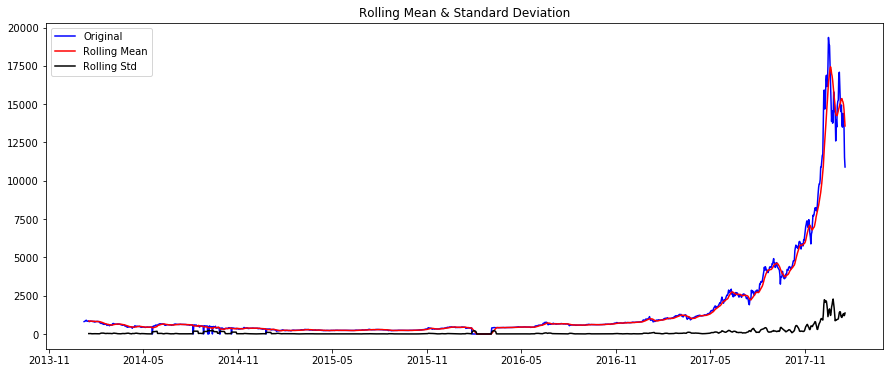

Results of Dickey-Fuller Test:
Test Statistic                   -1.943407
p-value                           0.311925
#Lags Used                       23.000000
Number of Observations Used    1448.000000
Critical Value (1%)              -3.434874
Critical Value (5%)              -2.863538
Critical Value (10%)             -2.567834
dtype: float64


In [76]:
test_stationarity(reg_data['Close'])

In [ ]:
#Conclusion: We can easily see that the time series is not stationary, and 
# our test_stationarity function confirms what we see.
# refer: https://machinelearningmastery.com/time-series-data-stationary-python/

#Results of Dickey-Fuller Test:
#Test Statistic                   -1.943407
#p-value                           0.311925
#Lags Used                       23.000000
#Next Step would be to make TS stationary


In [80]:
moving_avg = reg_data['Close'].rolling(window=10).mean()

In [104]:
moving_avg.dropna(inplace=True)
#print(moving_avg)

In [105]:
ts_log = np.log(reg_data['Close'])

C:\Users\kundami\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning:

divide by zero encountered in log



In [100]:
ts_log.dropna(inplace=True)
#print(ts_log)

In [101]:
ts_log_moving_avg_diff = ts_log - moving_avg

In [102]:
ts_log_moving_avg_diff.dropna(inplace=True)
#print(ts_log_moving_avg_diff)


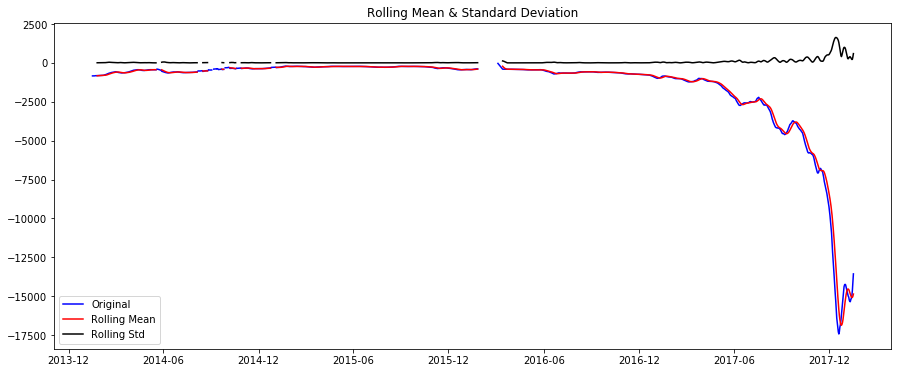

Results of Dickey-Fuller Test:


C:\Users\kundami\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1768: RuntimeWarning:

invalid value encountered in subtract

C:\Users\kundami\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1591: RuntimeWarning:

invalid value encountered in greater



LinAlgError: SVD did not converge

In [103]:
test_stationarity(ts_log_moving_avg_diff)

C:\Users\kundami\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()



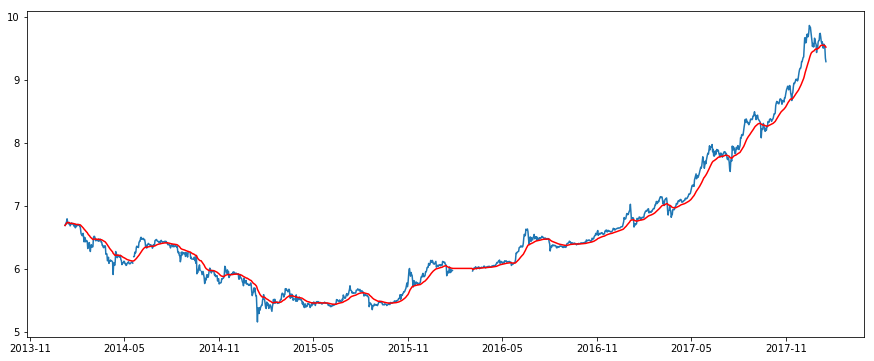

In [114]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

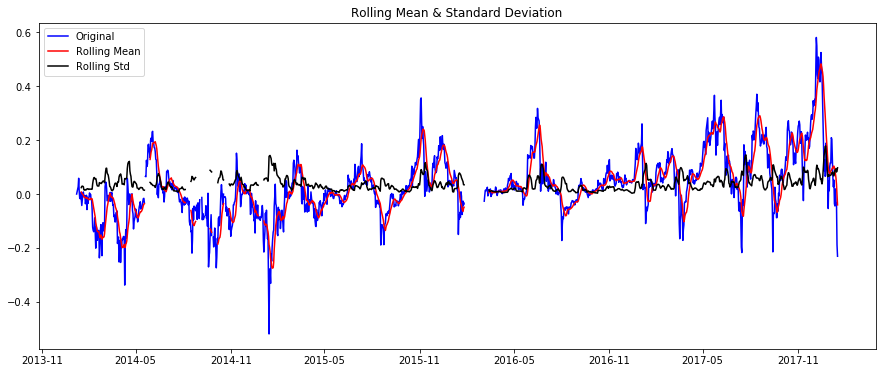

Results of Dickey-Fuller Test:


C:\Users\kundami\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1768: RuntimeWarning:

invalid value encountered in subtract

C:\Users\kundami\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1591: RuntimeWarning:

invalid value encountered in greater



LinAlgError: SVD did not converge

In [115]:
expwighted_avg.dropna(inplace=True)
ts_log_ewma_diff = ts_log - expwighted_avg

test_stationarity(ts_log_ewma_diff)

In [360]:
# Creating label by shifting 'Adj. Close' according to 'forecast_out'
df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head(2))
print('\n')
# If we look at the tail, it consists of n(=forecast_out) rows with NAN in Label column 
print(df.tail(2))

NameError: name 'df' is not defined

In [ ]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)